In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from skimage.transform import (estimate_transform, AffineTransform)
from neurodsp.sim import sim_oscillation

## Simulate

Various asine waves (rdsyms between 0.6 and 0.8) with lengths from 100-200 samples.

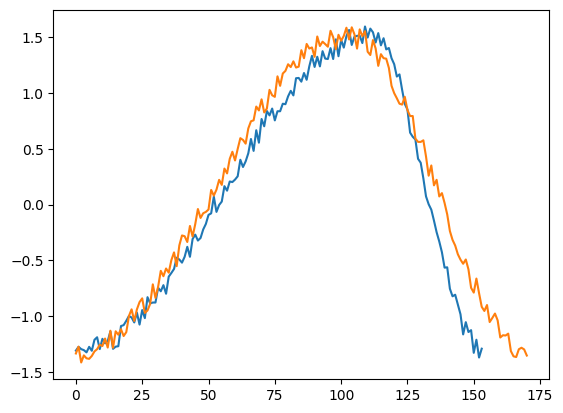

In [2]:
np.random.seed(0)
n_samples = np.random.uniform(100, 200, size=1000).astype(int)
rdsyms = np.random.uniform(.6, .8, size=1000)

sims = []
for i, n in enumerate(n_samples):
    np.random.seed(i)
    sims.append(sim_oscillation(1, n, 1, cycle='asine', phase='min', rdsym=rdsyms[i]) + np.random.rand(n)/5)

plt.plot(sims[0])
plt.plot(sims[1])

## Overfitting Polynomials

Use polynomials to get a scale free motif that can be generated at any size without requiring resampling. The goal of overfitting is to be able generate each cycle at any time resolution, rather than interpretion of coefficients.

Regardless of cycle size, we now have a set number of parameters per cycles. The motif can be taken as the polynomial from the mean of thse parameters and the motif can be moved into each individual cycle length.

In [3]:
params = np.zeros((len(sims), 33))

for i, y in enumerate(sims):

    x = np.linspace(0, 1, len(y))

    with warnings.catch_warnings():
        # Warns the we are overfitting
        warnings.simplefilter("ignore")
        ps = np.polyfit(x, y, 32)

    params[i] = ps

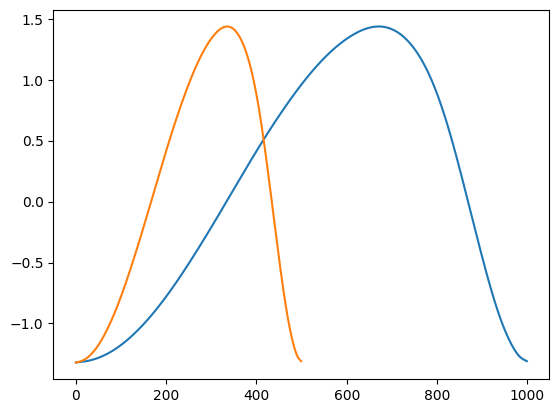

In [4]:
# Mean poly params == scale freq motif
params_mean = params.mean(axis=0)

plt.plot(np.poly1d(params_mean)(np.linspace(0, 1, 1000)))
plt.plot(np.poly1d(params_mean)(np.linspace(0, 1, 500)))

## Motif to Cycle Transformation

The affine transform from motif to cycle can now descibe the cycle-by-cycle variance of waveform shape. The correlations in affine size vs simulated rise-decay symmetry suggest the affine parameters accurately reflect the shape of each individual cycle.

It's important to note that these results depend on relative homogeneous cycle shapes (e.g. here is 0.6 yto 0.8 rise decay symmetry). Wider ranges (e.g. rdsym 0.2 to 0.8) will result in poor affine transformations. Clustering should then be used to sub-group motifs in cases where cycle-by-cycle variance is high.

In [5]:
rsq = np.zeros(1000)
affine_params = np.zeros((1000, 3, 3))

for i, y in enumerate(sims):
    
    x = np.linspace(0, 1, n_samples[i])
    
    motif = np.poly1d(params_mean)(x)

    
    src = np.vstack((x, motif)).T
    dst = np.vstack((x, y)).T
    
    tform = estimate_transform('affine', src, dst)
    y_est = AffineTransform(tform.params)(src).T[1]
    
    rsq[i] = np.corrcoef(y, y_est)[0][1]**2

    affine_params[i] = tform.params

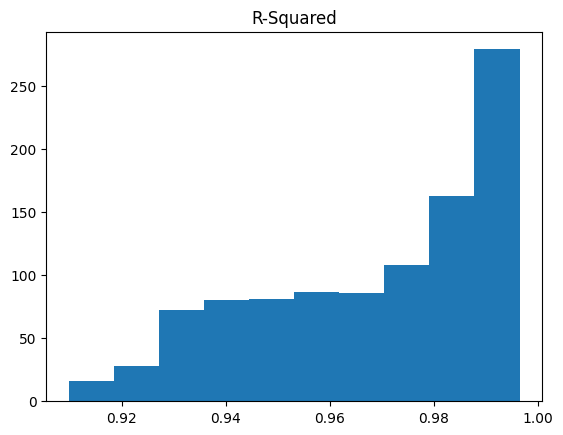

In [6]:
plt.title('R-Squared')
plt.hist(rsq);

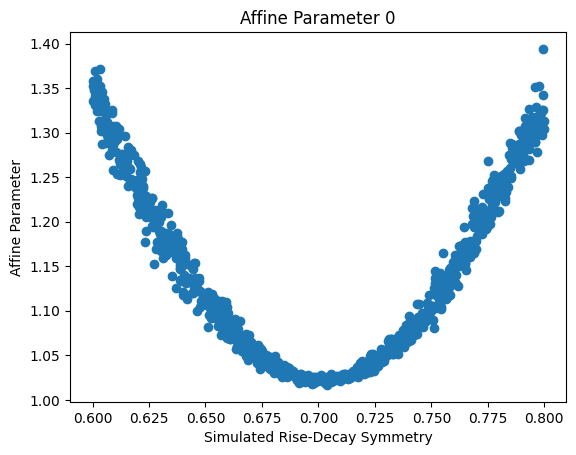

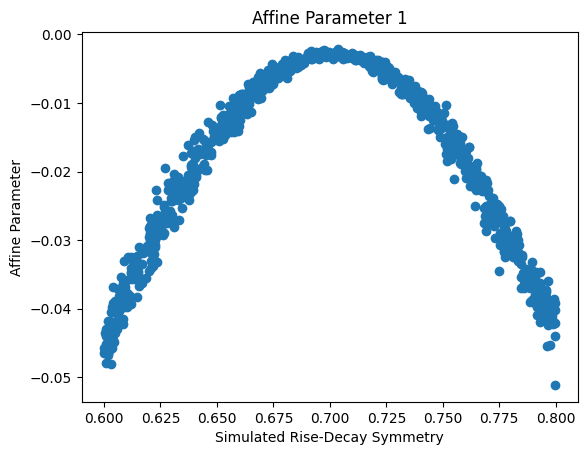

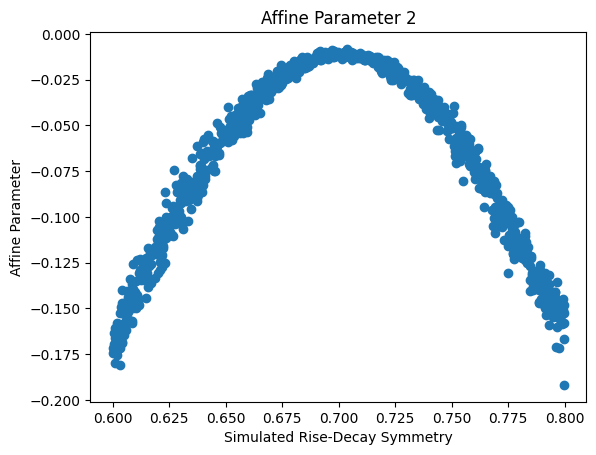

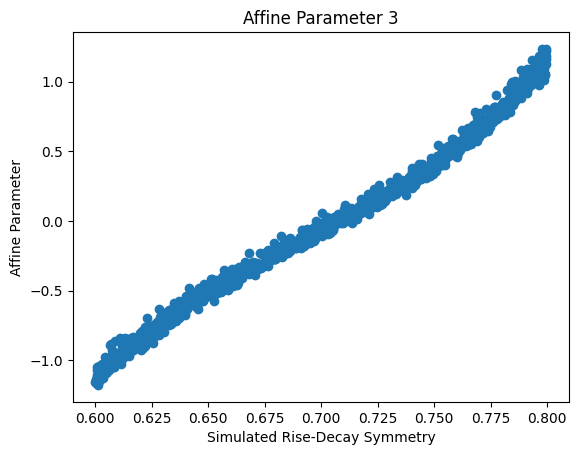

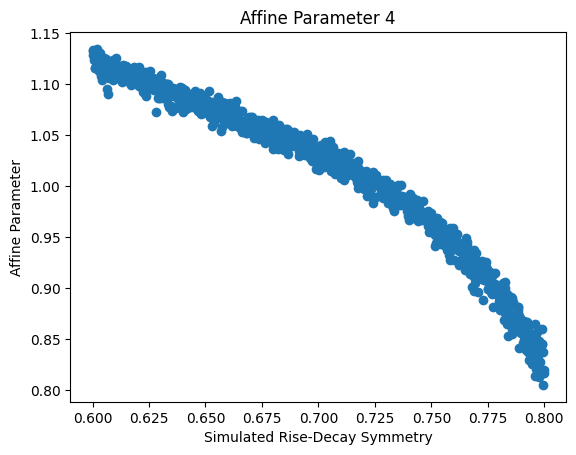

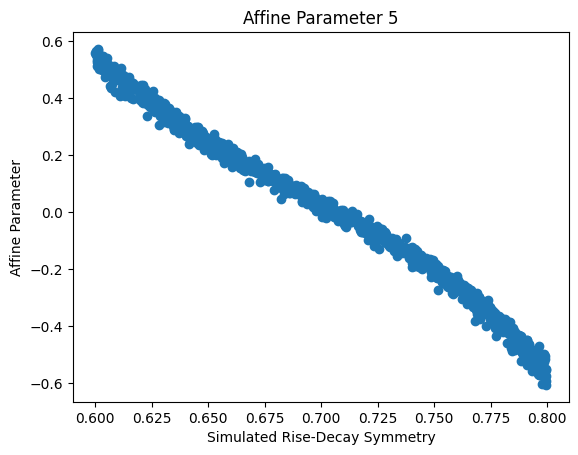

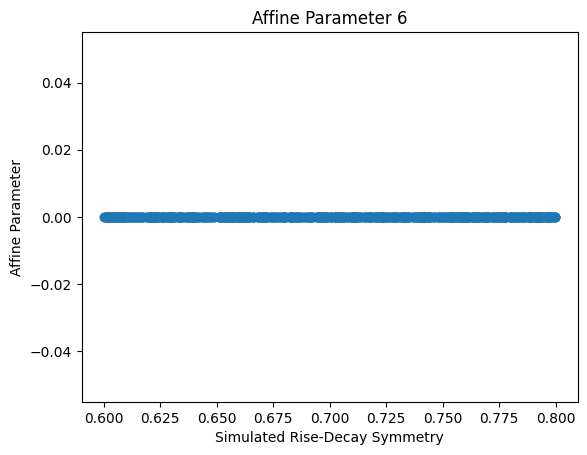

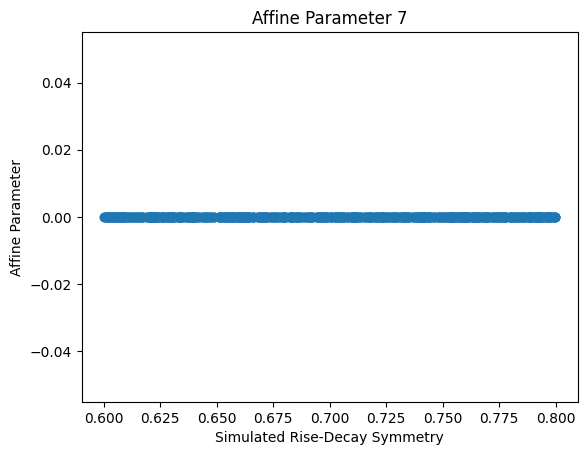

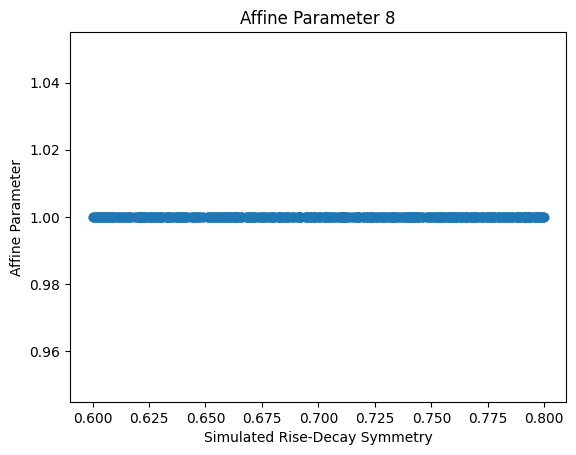

In [7]:
affine_params_flat = affine_params.reshape(1000, -1).T

for i in range(9):
    plt.figure(i)
    plt.title(f'Affine Parameter {i}')
    plt.scatter(rdsyms, affine_params_flat[i])  
    plt.xlabel('Simulated Rise-Decay Symmetry')
    plt.ylabel('Affine Parameter')